In [1]:
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import TensorDataset, DataLoader, Dataset
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
!nvidia-smi

Mon Jul 28 16:32:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.163.01             Driver Version: 550.163.01     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   51C    P8              6W /   80W |     515MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
%matplotlib inline

In [ ]:
!unzip rus-eng.zip

--2020-04-02 06:51:04--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 54.192.87.92, 54.192.87.42, 54.192.87.67, ...
Connecting to download.pytorch.org (download.pytorch.org)|54.192.87.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  17.6MB/s    in 0.2s    

2020-04-02 06:51:04 (17.6 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italia

In [ ]:
!mv rus.txt eng-rus.txt

In [ ]:
!tail eng-rus.txt

Five tremors in excess of magnitude 5.0 on the Richter scale have shaken Japan just this week, but scientists are warning that the largest expected aftershock has yet to hit.	Cinq secousses dépassant la magnitude cinq sur l'échelle de Richter ont secoué le Japon précisément cette semaine, mais les scientifiques avertissent que la plus grande réplique est encore à venir.
No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.	Peu importe le temps que tu passeras à essayer de convaincre les gens que le chocolat est de la vanille, ça restera toujours du chocolat, même si tu réussis à convaincre toi et quelques autres que c'est de la vanille.
A child who is a native speaker usually knows many things about his or her language that a non-native speaker who has been studying for years still does not know and perhaps will never know.	Un enfant qui est un locuteur natif

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    parts = s.split('\t')[:2]

    result = []
    for part in parts:
        normalized = unicodedata.normalize('NFC', part)
        result.append(normalized)
        
    return '\t'.join(result)

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-яА-Яйё.!?]+", r" ", s)
    return s

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:2] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [7]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 519900 sentence pairs
Trimmed to 30087 sentence pairs
Counting words...
Counted words:
rus 10529
eng 4377
['они полицейские .', 'they re the police .']


The Encoder
-----------





In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, model_type="GRU"):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_type = model_type

        self.embedding = nn.Embedding(input_size, hidden_size)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.rnn(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        if self.model_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

The Decoder
-----------




In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, model_type="GRU", dropout_p=0.1, max_length=MAX_LENGTH, attn_type="mlp"):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_type = model_type
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.attn_type = attn_type

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        if attn_type == "mlp":
            self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(self.hidden_size, self.hidden_size, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.GRU(self.hidden_size, self.hidden_size, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        if self.attn_type == "dot":
            attn_weights = F.softmax(torch.bmm(hidden[0].unsqueeze(1), encoder_outputs.transpose(1, 2)).squeeze(1), dim=1)
        else:  # mlp
            attn_weights = F.softmax(self.attn(torch.cat((embedded.view(-1, self.hidden_size), hidden[0]), 1)), dim=1)
        
        attn_applied = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        output = torch.cat((embedded.view(-1, self.hidden_size), attn_applied.squeeze(1)), 1)
        output = self.attn_combine(output).unsqueeze(1)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = F.log_softmax(self.out(output.squeeze(1)), dim=1)
        return output, hidden, attn_weights

    def initHidden(self, batch_size=1):
        if self.model_type == "LSTM":
            return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros(batch_size, max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden)
        encoder_outputs[:, ei, :] = encoder_output.squeeze(1)

    decoder_input = torch.tensor([[SOS_token]] * batch_size, device=device).view(batch_size, 1)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[:, di, :].squeeze(1))
            decoder_input = target_tensor[:, di, :]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.detach() # detach from history as input

            loss += criterion(decoder_output, target_tensor[:, di, :].squeeze(1))
            if (decoder_input == EOS_token).all():
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [13]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [15]:
plt.switch_backend('agg')
import matplotlib.ticker as ticker


def showPlot(iterations, points, name):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc_y = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc_y)
    ax.plot(iterations, points)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss vs Iterations')
    plt.savefig(name)
    plt.close()

In [16]:
def trainIters(encoder, decoder, n_iters, name, batch_size=8, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    iterations = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(n_iters)]
    input_tensors = nn.utils.rnn.pad_sequence([pair[0] for pair in training_pairs], batch_first=True, padding_value=0)
    target_tensors = nn.utils.rnn.pad_sequence([pair[1] for pair in training_pairs], batch_first=True, padding_value=0)
    dataset = TensorDataset(input_tensors, target_tensors)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    criterion = nn.NLLLoss()
    iter_count = 0

    for _ in range(1, (n_iters // batch_size) + 1):
        for batch_input, batch_target in dataloader:
            if iter_count >= n_iters:
                break

            loss = train(batch_input, batch_target, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss * batch_input.size(0)
            plot_loss_total += loss * batch_input.size(0)
            iter_count += batch_input.size(0)

            if iter_count % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, iter_count / n_iters), iter_count, iter_count / n_iters * 100, print_loss_avg))

            if iter_count % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                iterations.append(iter_count)
                plot_loss_total = 0

    showPlot(iterations, plot_losses, name=name)

    return plot_losses

In [17]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_tensor = input_tensor.view(1, -1, 1)
        input_length = input_tensor.size(1)

        encoder_hidden = encoder.initHidden(batch_size=1)

        encoder_outputs = torch.zeros(1, max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden)
            encoder_outputs[:, ei, :] = encoder_output.squeeze(1)

        decoder_input = torch.tensor([[SOS_token]], device=device).view(1, 1)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.data.topk(1)
            decoder_attentions[di] = decoder_attention.data
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [18]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [17]:
def evaluate_bleu(encoder, decoder, pairs):
    references = []
    hypotheses = []
    for pair in pairs:
        input_tensor, target_tensor = tensorsFromPair(pair)
        output_words = evaluate(encoder, decoder, input_tensor)
        references.append([pair[1].split()])
        hypotheses.append(output_words.split())
    return corpus_bleu(references, hypotheses)

# **Attention with cosine similarity**

In [21]:
hidden_size = 256
batch_size = 16

encoder_dot = EncoderRNN(input_lang.n_words, hidden_size, num_layers=2, model_type="GRU").to(device)
decoder_dot = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, num_layers=2, model_type="GRU", attn_type="dot").to(device)

trainIters(encoder_dot, decoder_dot, 1000000, name="dot_product_attn_GRU_2_layer.png", batch_size=batch_size, print_every=100000, plot_every=100000)

3m 13s (- 29m 0s) (100000 10%) 2.3995
5m 23s (- 21m 34s) (200000 20%) 1.8767
7m 36s (- 17m 45s) (300000 30%) 1.5861
9m 48s (- 14m 42s) (400000 40%) 1.3619
12m 0s (- 12m 0s) (500000 50%) 1.1731
14m 11s (- 9m 27s) (600000 60%) 1.0192
16m 24s (- 7m 1s) (700000 70%) 0.8883
18m 36s (- 4m 39s) (800000 80%) 0.7831
20m 46s (- 2m 18s) (900000 90%) 0.6982
22m 57s (- 0m 0s) (1000000 100%) 0.6243


[2.399464370590203,
 1.8766590404357895,
 1.5861398012619026,
 1.361942510452273,
 1.1730761766510072,
 1.01924582027435,
 0.8882976177787791,
 0.7831340986213657,
 0.6982420010833732,
 0.6242516702556615]

In [22]:
evaluateRandomly(encoder_dot, decoder_dot, 20)

> иду спать .
= i am going to sleep .
< i m going to be next this . <EOS>

> я не иностранка .
= i m not a foreigner .
< i m not a stranger of her . <EOS>

> она говорит что она вам перезвонит .
= she says she will call you later .
< she said she will call you your help . <EOS>

> я собираюсь принять ванну .
= i m going to take a bath .
< i m going to take a party . <EOS>

> я полноват .
= i m a little fat .
< i m a little of what tom . <EOS>

> она не менее красива чем сестра .
= she is not less beautiful than her sister .
< she is not less beautiful than her sister . <EOS>

> ты от меня что то скрываешь .
= you re hiding something from me .
< you re perfect something of me something . <EOS>

> я не обедаю с томом .
= i m not having lunch with tom .
< i m not good my with tom . <EOS>

> мы оскорблены .
= we re outraged .
< i m getting of this place . <EOS>

> ты настоящий друг .
= you re a real friend .
< you re really a fool friend . <EOS>

> очень рад с вами познакомиться .
= i m ve

# **Attention with MLP**

In [27]:
hidden_size = 256
batch_size = 16

encoder_mlp = EncoderRNN(input_lang.n_words, hidden_size, num_layers=2, model_type="GRU").to(device)
decoder_mlp = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, num_layers=2, model_type="GRU", attn_type="mlp").to(device)

trainIters(encoder_mlp, decoder_mlp, 1000000, name="mlp_attn_GRU_2_layer.png", batch_size=batch_size, print_every=100000, plot_every=100000)

3m 24s (- 30m 38s) (100000 10%) 2.4166
5m 57s (- 23m 51s) (200000 20%) 1.8788
8m 27s (- 19m 43s) (300000 30%) 1.5814
10m 59s (- 16m 29s) (400000 40%) 1.3572
13m 33s (- 13m 33s) (500000 50%) 1.1702
16m 9s (- 10m 46s) (600000 60%) 1.0190
18m 52s (- 8m 5s) (700000 70%) 0.8845
21m 36s (- 5m 24s) (800000 80%) 0.7742
24m 20s (- 2m 42s) (900000 90%) 0.6844
27m 3s (- 0m 0s) (1000000 100%) 0.6048


[2.4165907622680654,
 1.878760974166871,
 1.581431051597599,
 1.357158460731503,
 1.17024750354767,
 1.0189753959732026,
 0.8845151796569837,
 0.7742411463851946,
 0.684373688591003,
 0.6048253004150405]

<Figure size 640x480 with 0 Axes>

In [69]:
evaluateRandomly(encoder_mlp, decoder_mlp, 20)

> она не из тех кто выходит замуж .
= she s not the marrying type .
< she is not the same we . <EOS>

> я готов ко всему что угодно .
= i m ready for anything .
< i m ready for anything . <EOS>

> ты слишком тощая .
= you re too skinny .
< you re too much for this . . <EOS>

> ты безнадёжен .
= you re desperate .
< you re a bit man to the . <EOS>

> вы упрямые .
= you re obstinate .
< you re free to a a lot . <EOS>

> вы неправильно идёте .
= you re going the wrong way .
< you re not the wrong train to . <EOS>

> я так рад что вы пришли !
= i m so glad you ve come .
< i m so glad you came come . <EOS>

> вам рано жениться .
= you re too young to get married .
< you re too young to travel things yourself . <EOS>

> я за томом .
= i m behind tom .
< i m coming tom and out news . <EOS>

> прости меня за всё .
= i m sorry for everything .
< i m sorry for being treated way . <EOS>

> мы больше не встречаемся .
= we re not seeing each other anymore .
< we re not expecting any answer to . <EO

# **Comparison examples**

In [78]:
def showAttention(input_sentence, output_words, attentions, ax):
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    plt.colorbar(cax, ax=ax)

    ax.set_xticks(range(len(input_sentence.split(' ')) + 1))
    ax.set_yticks(range(len(output_words)))

    ax.set_xticklabels(input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels(output_words)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

def evaluateAndShowAttention(encoder, decoder, input_sentence, ax):
    output_words, attentions = evaluate(encoder, decoder, input_sentence)
    # print('input =', input_sentence)
    # print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions, ax)

In [99]:
inputs = [
    "я никуда не пойду .",
    "мы не ждём от тебя никакой помощи .",
    "мне стыдно за то что я сделал .",
    "простите я забыл ваше имя .",
    "она не из тех кто выходит замуж .",
    "ты слишком тощая .",
    "вы упрямые .",
    "он слепнет ."
]

## **Right examples**

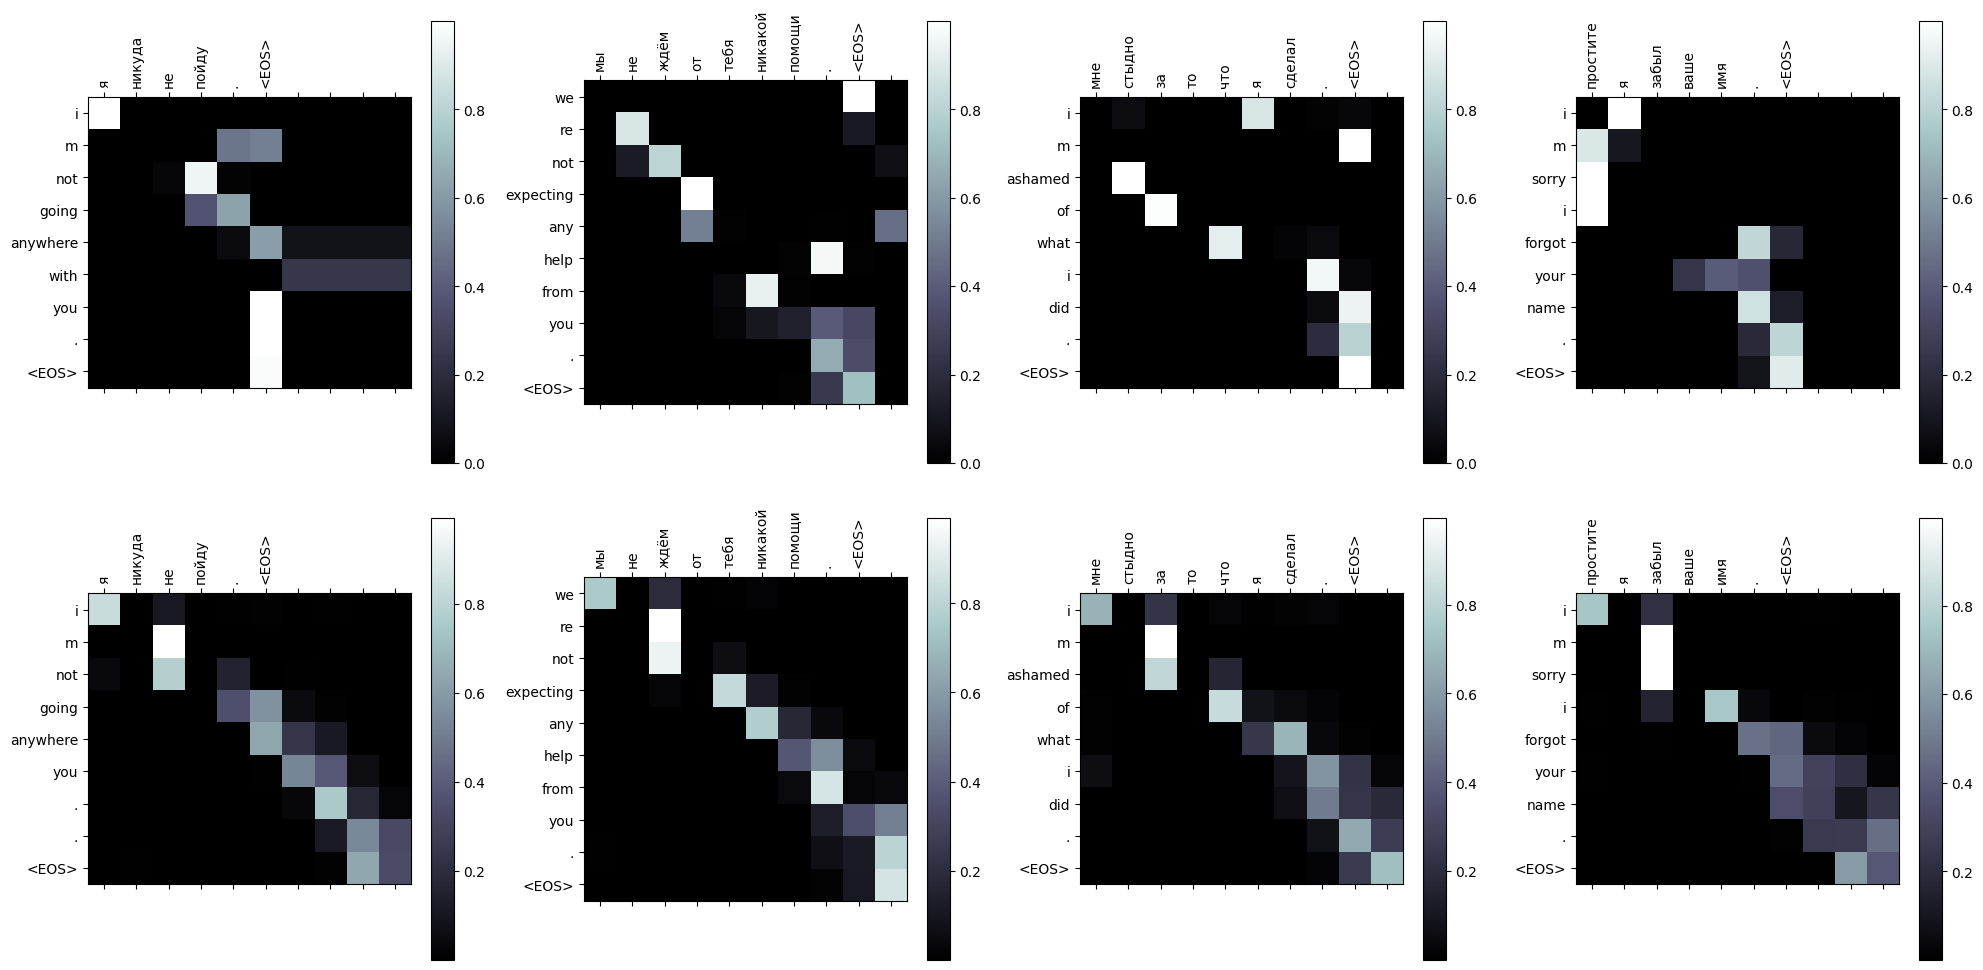

In [100]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, input_sentence in enumerate(inputs[:4]):
    evaluateAndShowAttention(encoder_dot, decoder_dot, input_sentence, axes[0, i])
    evaluateAndShowAttention(encoder_mlp, decoder_mlp, input_sentence, axes[1, i])

plt.tight_layout()
plt.show()

## **Wrong examples**

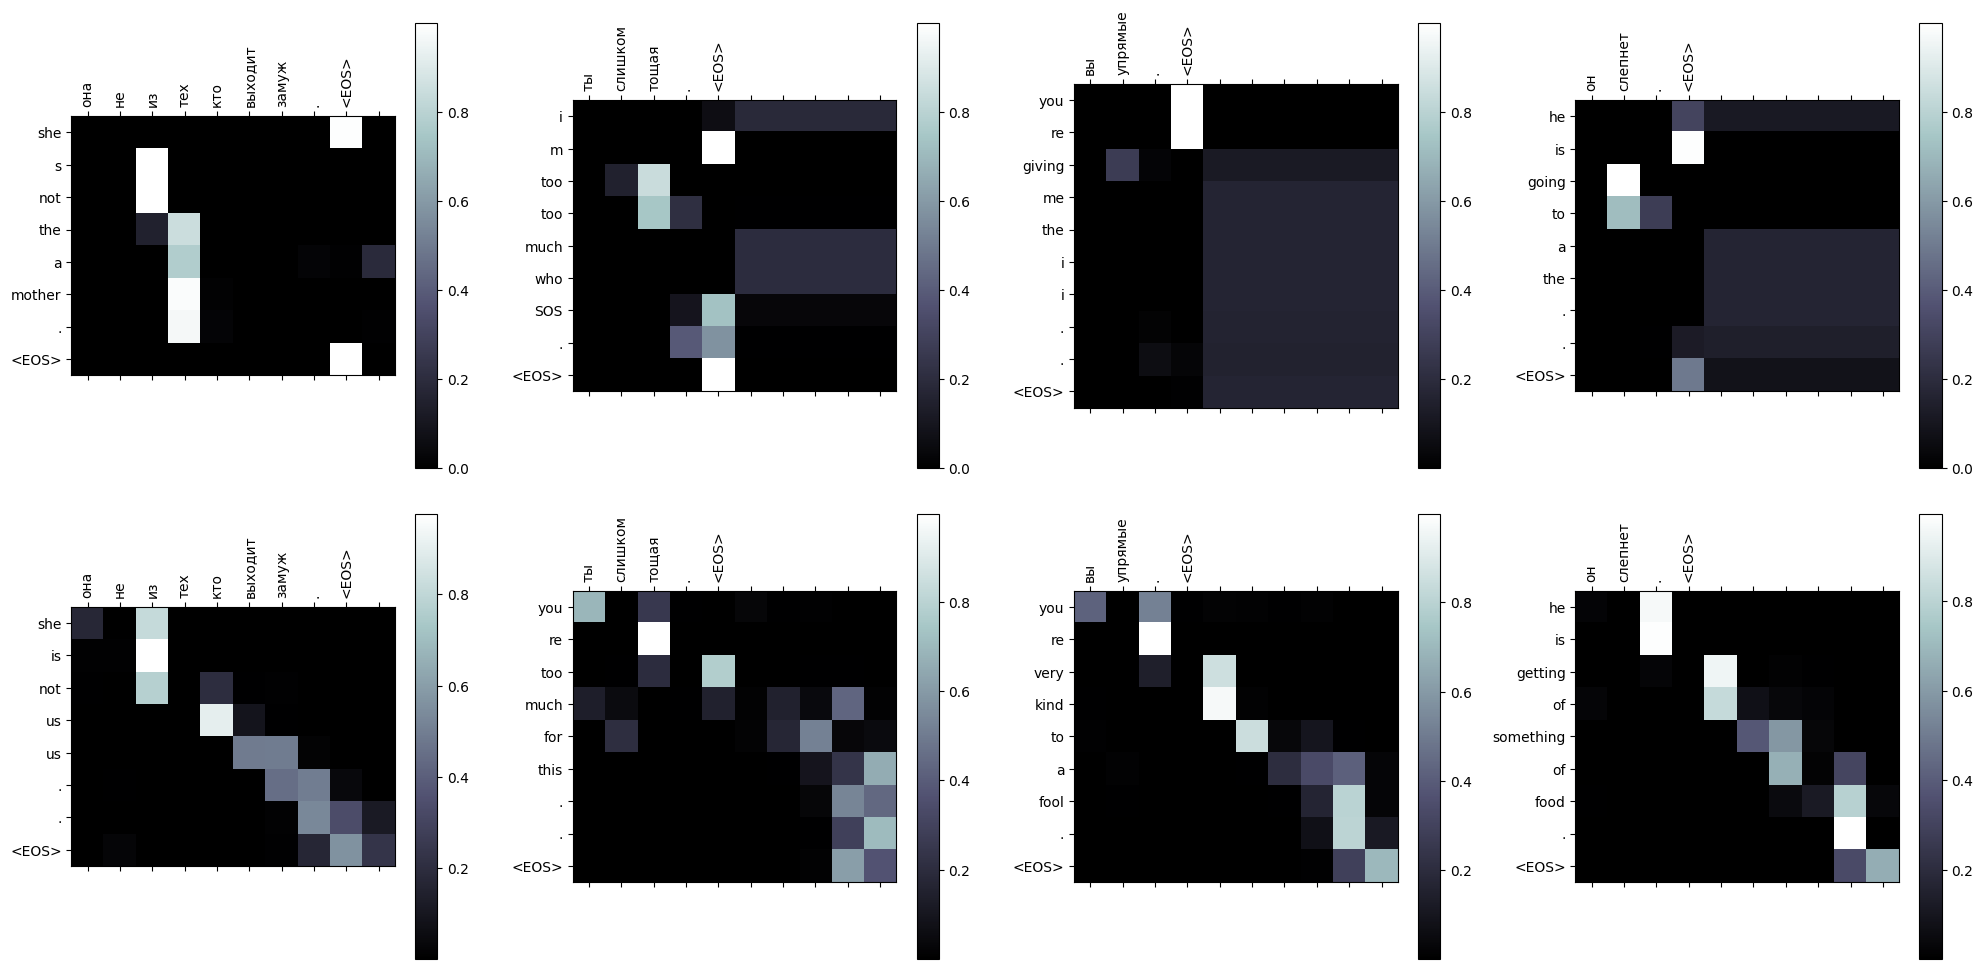

In [101]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, input_sentence in enumerate(inputs[4:]):
    evaluateAndShowAttention(encoder_dot, decoder_dot, input_sentence, axes[0, i])
    evaluateAndShowAttention(encoder_mlp, decoder_mlp, input_sentence, axes[1, i])

plt.tight_layout()
plt.show()

# **Results**

In [47]:
df_results = pd.DataFrame({
    'iterations': np.arange(100000, 1100000, 100000),
    'loss_dot_product': [
        2.399464370590203,
        1.8766590404357895,
        1.5861398012619026,
        1.361942510452273,
        1.1730761766510072,
        1.01924582027435,
        0.8882976177787791,
        0.7831340986213657,
        0.6982420010833732,
        0.6242516702556615
    ],
    'loss_mlp': [
        2.4165907622680654,
        1.878760974166871,
        1.581431051597599,
        1.357158460731503,
        1.17024750354767,
        1.0189753959732026,
        0.8845151796569837,
        0.7742411463851946,
        0.684373688591003,
        0.6048253004150405
    ]
})
df_results

,iterations,loss_dot_product,loss_mlp
0,100000,2.399464,2.416591
1,200000,1.876659,1.878761
2,300000,1.586140,1.581431
3,400000,1.361943,1.357158
4,500000,1.173076,1.170248
5,600000,1.019246,1.018975
6,700000,0.888298,0.884515
7,800000,0.783134,0.774241
8,900000,0.698242,0.684374
9,1000000,0.624252,0.604825


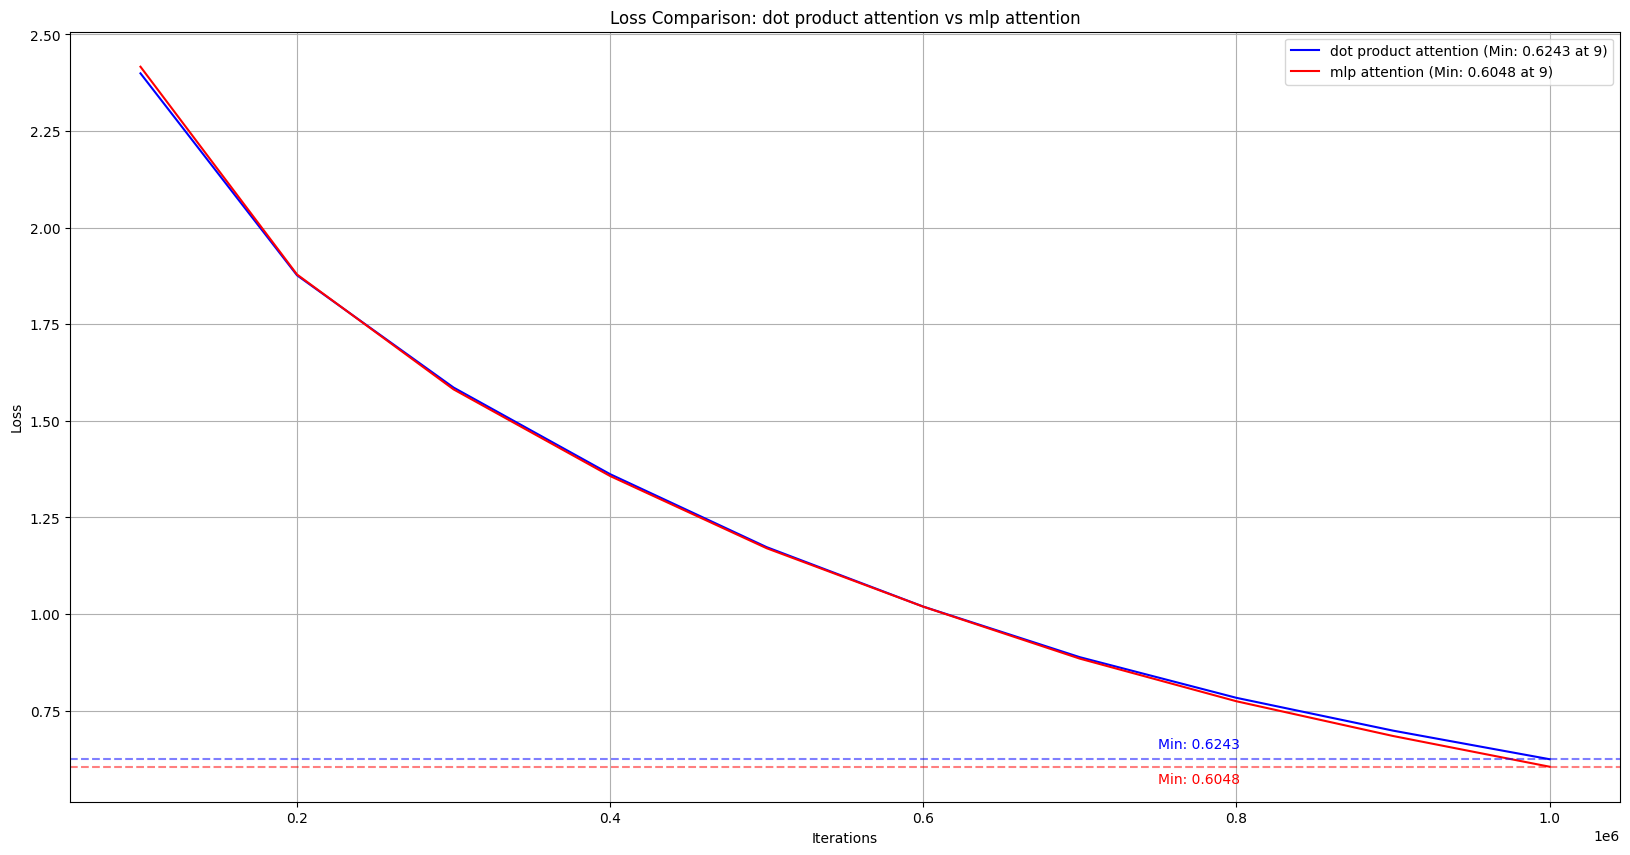

In [52]:
plt.figure(figsize=(20, 10))
plt.plot(
    df_results['iterations'], df_results['loss_dot_product'],
    label=f'dot product attention (Min: {min(df_results['loss_dot_product']):.4f} at {df_results['loss_dot_product'].idxmin()})',
    color='blue'
)
plt.plot(
    df_results['iterations'], df_results['loss_mlp'],
    label=f'mlp attention (Min: {min(df_results['loss_mlp']):.4f} at {df_results['loss_mlp'].idxmin()})',
    color='red'
)

plt.axhline(y=min(df_results['loss_dot_product']), color='blue', linestyle='--', alpha=0.5)
plt.axhline(y=min(df_results['loss_mlp']), color='red', linestyle='--', alpha=0.5)

plt.text(
    750000, min(df_results['loss_dot_product']) + 0.02, 
    f'Min: {min(df_results['loss_dot_product']):.4f}', 
    color='blue', ha='left', va='bottom'
)
plt.text(
    750000, min(df_results['loss_mlp']) - 0.05, 
    f'Min: {min(df_results['loss_mlp']):.4f}', 
    color='red', ha='left', va='bottom'
)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Comparison: dot product attention vs mlp attention')
plt.legend()
plt.grid(True)
plt.show()

# **Выводы**

## **1. Метрики качества в моделях с двумя видами механизмов внимания, показали примерно одинаковые результаты.**
## **2. Модель с механизмом внимания, основанным на косинусном сходстве, обучается быстрее, чем модель с MLP (примерно на 10 %)**
## **3. На мой взгляд, фактический результат перевода для обеих моделей одинаков, что видно на приведенных примерах сравнения качественных и некачественных переводов. Есть предположение, что увеличение словаря и снятие ограничений на обучаему выборку улучшит качество переводов.**